# BirdCLEF CNN on Mel Spectrograms (From Scratch)

This notebook trains a CNN model from scratch on mel spectrograms for the BirdCLEF 2025 competition, based on successful approaches from music genre classification.

In [1]:
# Install required packages for Google Colab
!pip install -q librosa scikit-image torchsummary gdown

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import soundfile as sf
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import seaborn as sns
import gdown

# Set seeds for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed()

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Loading and Configuration

Define paths and constants for the dataset

In [4]:
# Define paths
DATA_PATH = '/content/drive/MyDrive/birdclef-2025-data'
MODEL_SAVE_DIR = '/content/drive/MyDrive/birdclef-2025-models'
AUDIO_DIR = os.path.join(DATA_PATH, 'train_audio')
TRAIN_CSV = os.path.join(DATA_PATH, 'train.csv')
MODEL_SAVE_PATH = os.path.join(MODEL_SAVE_DIR, 'bird_cnn_scratch.pt')

# Create model save directory if it doesn't exist
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

# Verify paths
print(f"Data path exists: {os.path.exists(DATA_PATH)}")
print(f"Model save directory: {MODEL_SAVE_DIR}")

# Load the metadata
train_df = pd.read_csv(TRAIN_CSV)
print(f"Training data shape: {train_df.shape}")
print(f"Unique species: {train_df['primary_label'].nunique()}")
train_df.head()

Data path exists: True
Model save directory: /content/drive/MyDrive/birdclef-2025-models
Training data shape: (28564, 13)
Unique species: 206


,primary_label,secondary_labels,type,filename,collection,rating,url,latitude,longitude,scientific_name,common_name,author,license
0,1139490,[''],[''],1139490/CSA36385.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0
1,1139490,[''],[''],1139490/CSA36389.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0
2,1192948,[''],[''],1192948/CSA36358.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0
3,1192948,[''],[''],1192948/CSA36366.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.2800,-73.8582,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0
4,1192948,[''],[''],1192948/CSA36373.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0


## Using Precomputed Features

Load precomputed mel spectrograms from a shared Google Drive link to skip the time-consuming feature extraction process.

In [5]:
# URL for the shared Google Drive file
PRECOMPUTED_FEATURES_URL = "https://drive.google.com/file/d/1bkkglM6lV1aV-9bSsVpD475YewPwblmL/view?usp=sharing"
PRECOMPUTED_FEATURES_PATH = "bird_features_scratch.npz"

def load_precomputed_features(url=PRECOMPUTED_FEATURES_URL, local_path=PRECOMPUTED_FEATURES_PATH):
    """Download and load precomputed features from Google Drive."""
    # Check if file already exists
    if not os.path.exists(local_path):
        print(f"Downloading precomputed features file to {local_path}...")
        # Use gdown to download the file from Google Drive
        gdown.download(url, local_path, quiet=False, fuzzy=True)
    else:
        print(f"Precomputed features file already exists at {local_path}")

    # Load the features
    print("Loading precomputed features...")
    try:
        data = np.load(local_path)
        X = data['data']
        y = data['labels']
        print(f"Successfully loaded precomputed features!")
        print(f"Features shape: {X.shape}")
        print(f"Labels shape: {y.shape}")
        print(f"Number of unique classes: {len(np.unique(y))}")
        return X, y
    except Exception as e:
        print(f"Error loading precomputed features: {e}")
        return None, None

# Load the precomputed features
X, y = load_precomputed_features()

Downloading...
From (original): https://drive.google.com/uc?id=1bkkglM6lV1aV-9bSsVpD475YewPwblmL
From (redirected): https://drive.google.com/uc?id=1bkkglM6lV1aV-9bSsVpD475YewPwblmL&confirm=t&uuid=88b8e37a-80c8-47b4-b721-6af09bea7c54
To: /content/bird_features_scratch.npz
100%|██████████| 24.9G/24.9G [05:24<00:00, 76.7MB/s]


Loading precomputed features...
Successfully loaded precomputed features!
Features shape: (190153, 1, 128, 256)
Labels shape: (190153,)
Number of unique classes: 206


## Data Preparation

Prepare the dataset for training by handling classes with only one sample and splitting into train/validation sets.

In [6]:
# Count occurrences of each label
label_counts = np.bincount(y)
print(f"Number of classes with only one sample: {np.sum(label_counts == 1)}")

# Handle classes with only one sample
if np.any(label_counts == 1):
    print("Handling classes with only one sample...")
    # Remove classes with only one sample
    valid_indices = np.isin(y, np.where(label_counts >= 2)[0])
    X = X[valid_indices]
    y = y[valid_indices]
    print(f"Removed {np.sum(~valid_indices)} samples with singleton classes")
    print(f"Remaining data shape: {X.shape}")

# Split into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create data loaders
train_loader = DataLoader(
    TensorDataset(X_train_tensor, y_train_tensor),
    batch_size=32,
    shuffle=True
)

val_loader = DataLoader(
    TensorDataset(X_test_tensor, y_test_tensor),
    batch_size=32,
    shuffle=False
)

Number of classes with only one sample: 0


## Model Definition

Define a CNN model from scratch, adapted for bird sound classification

In [7]:
class BirdCNN(nn.Module):
    def __init__(self, input_channels=1, num_classes=None):
        super(BirdCNN, self).__init__()

        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2),

            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3),

            # Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.4),

            # Block 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.4),
        )

        # Calculate size after convolutions
        # For 128x256 input, after 4 max pooling operations: 128/(2^4) x 256/(2^4) = 8x16
        self.feature_dims = 256 * 8 * 16  # Channels * Height * Width

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.feature_dims, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        # Input x should be [batch, channels, height, width]
        x = self.features(x)
        x = self.classifier(x)
        return x

# Create model (needs number of classes)
num_classes = len(np.unique(y))
model = BirdCNN(input_channels=1, num_classes=num_classes)
model = model.to(device)

# Print model summary
from torchsummary import summary
summary(model, (1, 128, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 256]             320
       BatchNorm2d-2         [-1, 32, 128, 256]              64
              ReLU-3         [-1, 32, 128, 256]               0
            Conv2d-4         [-1, 32, 128, 256]           9,248
       BatchNorm2d-5         [-1, 32, 128, 256]              64
              ReLU-6         [-1, 32, 128, 256]               0
         MaxPool2d-7          [-1, 32, 64, 128]               0
           Dropout-8          [-1, 32, 64, 128]               0
            Conv2d-9          [-1, 64, 64, 128]          18,496
      BatchNorm2d-10          [-1, 64, 64, 128]             128
             ReLU-11          [-1, 64, 64, 128]               0
           Conv2d-12          [-1, 64, 64, 128]          36,928
      BatchNorm2d-13          [-1, 64, 64, 128]             128
             ReLU-14          [-1, 64, 

## Model Training

Set up training hyperparameters and optimizer

In [8]:
# Define optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True
)

# Training parameters
num_epochs = 50
early_stopping_patience = 10
best_val_loss = float('inf')
epochs_without_improvement = 0

# For tracking metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [9]:
# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")):
        # Move to device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / total
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Statistics
            val_running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            # Store predictions for metrics calculation
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = val_running_loss / val_total
    val_accuracy = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}% - "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

    # Learning rate scheduler
    scheduler.step(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        # Save the best model
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print(f"Model saved to {MODEL_SAVE_PATH}")
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

Epoch 1/50 [Train]:   0%|          | 0/4754 [00:00<?, ?it/s]

Epoch 1/50 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Epoch 1/50 - Train Loss: 2.9246, Train Acc: 35.42% - Val Loss: 2.6376, Val Acc: 42.30%
Model saved to /content/drive/MyDrive/birdclef-2025-models/bird_cnn_scratch.pt


Epoch 2/50 [Train]:   0%|          | 0/4754 [00:00<?, ?it/s]

Epoch 2/50 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Epoch 2/50 - Train Loss: 2.0637, Train Acc: 52.57% - Val Loss: 1.6177, Val Acc: 62.71%
Model saved to /content/drive/MyDrive/birdclef-2025-models/bird_cnn_scratch.pt


Epoch 3/50 [Train]:   0%|          | 0/4754 [00:00<?, ?it/s]

Epoch 3/50 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Epoch 3/50 - Train Loss: 1.6855, Train Acc: 60.34% - Val Loss: 1.4105, Val Acc: 67.37%
Model saved to /content/drive/MyDrive/birdclef-2025-models/bird_cnn_scratch.pt


Epoch 4/50 [Train]:   0%|          | 0/4754 [00:00<?, ?it/s]

Epoch 4/50 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Epoch 4/50 - Train Loss: 1.4390, Train Acc: 65.48% - Val Loss: 1.2538, Val Acc: 70.79%
Model saved to /content/drive/MyDrive/birdclef-2025-models/bird_cnn_scratch.pt


Epoch 5/50 [Train]:   0%|          | 0/4754 [00:00<?, ?it/s]

Epoch 5/50 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Epoch 5/50 - Train Loss: 1.2452, Train Acc: 69.45% - Val Loss: 1.1249, Val Acc: 73.65%
Model saved to /content/drive/MyDrive/birdclef-2025-models/bird_cnn_scratch.pt


Epoch 6/50 [Train]:   0%|          | 0/4754 [00:00<?, ?it/s]

Epoch 6/50 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Epoch 6/50 - Train Loss: 1.1049, Train Acc: 72.22% - Val Loss: 1.1301, Val Acc: 73.47%


Epoch 7/50 [Train]:   0%|          | 0/4754 [00:00<?, ?it/s]

Epoch 7/50 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Epoch 7/50 - Train Loss: 0.9858, Train Acc: 74.81% - Val Loss: 0.9918, Val Acc: 76.87%
Model saved to /content/drive/MyDrive/birdclef-2025-models/bird_cnn_scratch.pt


Epoch 8/50 [Train]:   0%|          | 0/4754 [00:00<?, ?it/s]

Epoch 8/50 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Epoch 8/50 - Train Loss: 0.8904, Train Acc: 76.92% - Val Loss: 0.9876, Val Acc: 77.31%
Model saved to /content/drive/MyDrive/birdclef-2025-models/bird_cnn_scratch.pt


Epoch 9/50 [Train]:   0%|          | 0/4754 [00:00<?, ?it/s]

Epoch 9/50 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Epoch 9/50 - Train Loss: 0.8223, Train Acc: 78.21% - Val Loss: 0.9822, Val Acc: 76.92%
Model saved to /content/drive/MyDrive/birdclef-2025-models/bird_cnn_scratch.pt


Epoch 10/50 [Train]:   0%|          | 0/4754 [00:00<?, ?it/s]

Epoch 10/50 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Epoch 10/50 - Train Loss: 0.7535, Train Acc: 79.77% - Val Loss: 0.9340, Val Acc: 78.47%
Model saved to /content/drive/MyDrive/birdclef-2025-models/bird_cnn_scratch.pt


Epoch 11/50 [Train]:   0%|          | 0/4754 [00:00<?, ?it/s]

Epoch 11/50 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Epoch 11/50 - Train Loss: 0.6974, Train Acc: 81.02% - Val Loss: 0.8788, Val Acc: 79.55%
Model saved to /content/drive/MyDrive/birdclef-2025-models/bird_cnn_scratch.pt


Epoch 12/50 [Train]:   0%|          | 0/4754 [00:00<?, ?it/s]

Epoch 12/50 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Epoch 12/50 - Train Loss: 0.6570, Train Acc: 81.80% - Val Loss: 0.8794, Val Acc: 80.16%


Epoch 13/50 [Train]:   0%|          | 0/4754 [00:00<?, ?it/s]

Epoch 13/50 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Epoch 13/50 - Train Loss: 0.6228, Train Acc: 82.73% - Val Loss: 1.0081, Val Acc: 78.22%


Epoch 14/50 [Train]:   0%|          | 0/4754 [00:00<?, ?it/s]

Epoch 14/50 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Epoch 14/50 - Train Loss: 0.5949, Train Acc: 83.30% - Val Loss: 0.9024, Val Acc: 79.78%


Epoch 15/50 [Train]:   0%|          | 0/4754 [00:00<?, ?it/s]

Epoch 15/50 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Epoch 15/50 - Train Loss: 0.5627, Train Acc: 84.13% - Val Loss: 0.9854, Val Acc: 77.86%


Epoch 16/50 [Train]:   0%|          | 0/4754 [00:00<?, ?it/s]

Epoch 16/50 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Epoch 16/50 - Train Loss: 0.4200, Train Acc: 87.93% - Val Loss: 0.8596, Val Acc: 81.78%
Model saved to /content/drive/MyDrive/birdclef-2025-models/bird_cnn_scratch.pt


Epoch 17/50 [Train]:   0%|          | 0/4754 [00:00<?, ?it/s]

Epoch 17/50 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Epoch 17/50 - Train Loss: 0.3702, Train Acc: 89.21% - Val Loss: 0.8388, Val Acc: 82.51%
Model saved to /content/drive/MyDrive/birdclef-2025-models/bird_cnn_scratch.pt


Epoch 18/50 [Train]:   0%|          | 0/4754 [00:00<?, ?it/s]

Epoch 18/50 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Epoch 18/50 - Train Loss: 0.3437, Train Acc: 89.86% - Val Loss: 0.8756, Val Acc: 82.05%


Epoch 19/50 [Train]:   0%|          | 0/4754 [00:00<?, ?it/s]

Epoch 19/50 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Epoch 19/50 - Train Loss: 0.3260, Train Acc: 90.38% - Val Loss: 0.9005, Val Acc: 82.00%


Epoch 20/50 [Train]:   0%|          | 0/4754 [00:00<?, ?it/s]

Epoch 20/50 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Epoch 20/50 - Train Loss: 0.3111, Train Acc: 90.79% - Val Loss: 0.8955, Val Acc: 82.40%


Epoch 21/50 [Train]:   0%|          | 0/4754 [00:00<?, ?it/s]

Epoch 21/50 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Epoch 21/50 - Train Loss: 0.2982, Train Acc: 91.16% - Val Loss: 0.8986, Val Acc: 82.28%


Epoch 22/50 [Train]:   0%|          | 0/4754 [00:00<?, ?it/s]

Epoch 22/50 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Epoch 22/50 - Train Loss: 0.2418, Train Acc: 92.77% - Val Loss: 0.8905, Val Acc: 82.90%


Epoch 23/50 [Train]:   0%|          | 0/4754 [00:00<?, ?it/s]

Epoch 23/50 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Epoch 23/50 - Train Loss: 0.2200, Train Acc: 93.40% - Val Loss: 0.8806, Val Acc: 83.32%


Epoch 24/50 [Train]:   0%|          | 0/4754 [00:00<?, ?it/s]

Epoch 24/50 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Epoch 24/50 - Train Loss: 0.2064, Train Acc: 93.79% - Val Loss: 0.9052, Val Acc: 83.35%


Epoch 25/50 [Train]:   0%|          | 0/4754 [00:00<?, ?it/s]

Epoch 25/50 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Epoch 25/50 - Train Loss: 0.1994, Train Acc: 94.00% - Val Loss: 0.8845, Val Acc: 83.42%


Epoch 26/50 [Train]:   0%|          | 0/4754 [00:00<?, ?it/s]

Epoch 26/50 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Epoch 26/50 - Train Loss: 0.1743, Train Acc: 94.72% - Val Loss: 0.9064, Val Acc: 83.61%


Epoch 27/50 [Train]:   0%|          | 0/4754 [00:00<?, ?it/s]

Epoch 27/50 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Epoch 27/50 - Train Loss: 0.1637, Train Acc: 95.04% - Val Loss: 0.8958, Val Acc: 83.68%
Early stopping at epoch 27


## Results Visualization

Visualize training progress and model performance

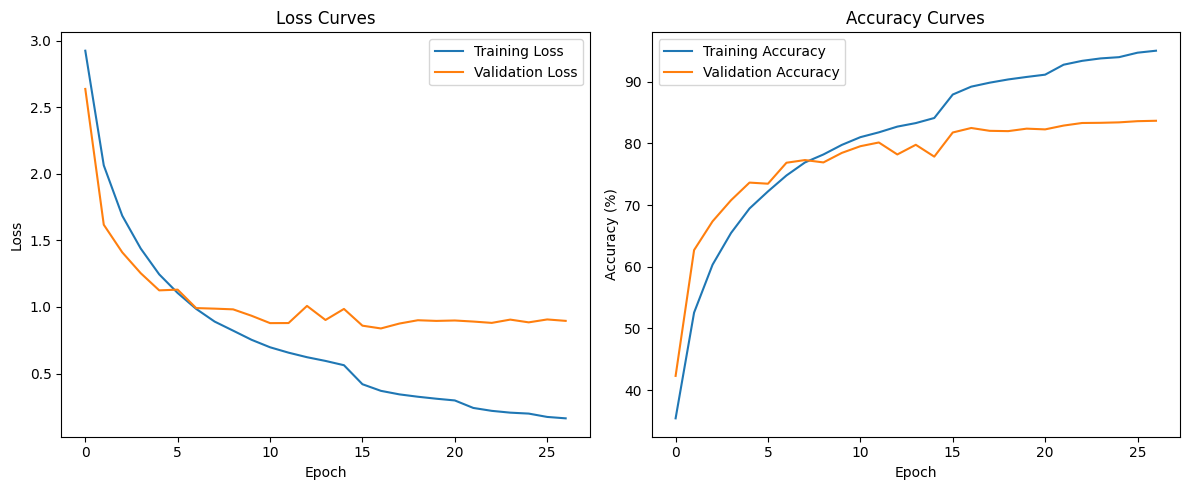

In [10]:
# Visualize training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

# Visualize training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curves')
plt.legend()

plt.tight_layout()
plt.show()

## Model Evaluation

Evaluate the model on the validation set with metrics relevant to BirdCLEF

In [12]:
# Load the best model
model.load_state_dict(torch.load(MODEL_SAVE_PATH))
model.eval()

# Evaluate on validation set
all_predictions = []
all_labels = []
all_probabilities = []

with torch.no_grad():
    for inputs, labels in tqdm(val_loader, desc="Evaluating"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)

        _, predicted = torch.max(outputs, 1)

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probabilities.append(probabilities.cpu().numpy())

# Convert to numpy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)
all_probabilities = np.concatenate(all_probabilities, axis=0)

# Calculate metrics
accuracy = np.mean(all_predictions == all_labels) * 100

# For ROC-AUC we need one-hot encoded labels
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
labels_onehot = encoder.fit_transform(all_labels.reshape(-1, 1))

# Get numeric class names (for clarity since we're using precomputed features)
class_names = [f"class_{i}" for i in range(num_classes)]

try:
    # Calculate macro average AUC (similar to competition metric)
    roc_auc = roc_auc_score(labels_onehot, all_probabilities, multi_class='ovr', average='macro')
    print(f"Validation Accuracy: {accuracy:.2f}%")
    print(f"Validation ROC-AUC: {roc_auc:.4f}")
except Exception as e:
    print(f"Error calculating ROC-AUC: {e}")
    print(f"Validation Accuracy: {accuracy:.2f}%")

# Print classification report (limited to top 20 classes for readability)
top_classes = 20  # Adjust based on number of classes
report_classes = class_names[:top_classes] if len(class_names) > top_classes else class_names
print("\nClassification Report (Top 20 classes):")
print(classification_report(
    all_labels,
    all_predictions,
    target_names=report_classes,
    labels=range(len(report_classes)),
    zero_division=0
))

Evaluating:   0%|          | 0/1189 [00:00<?, ?it/s]

Error calculating ROC-AUC: index 204 is out of bounds for axis 1 with size 204
Validation Accuracy: 82.51%

Classification Report (Top 20 classes):
              precision    recall  f1-score   support

     class_0       0.33      0.12      0.18         8
     class_1       0.14      0.12      0.13        17
     class_2       1.00      1.00      1.00         3
     class_3       0.75      1.00      0.86         3
     class_4       0.92      1.00      0.96        12
     class_5       1.00      1.00      1.00         5
     class_6       0.98      0.92      0.95        50
     class_7       0.00      0.00      0.00        12
     class_8       0.51      0.79      0.62        28
     class_9       1.00      1.00      1.00         1
    class_10       1.00      0.94      0.97        16
    class_11       0.00      0.00      0.00         0
    class_12       0.87      0.84      0.86        57
    class_13       1.00      0.93      0.97        30
    class_14       0.85      0.88      0.

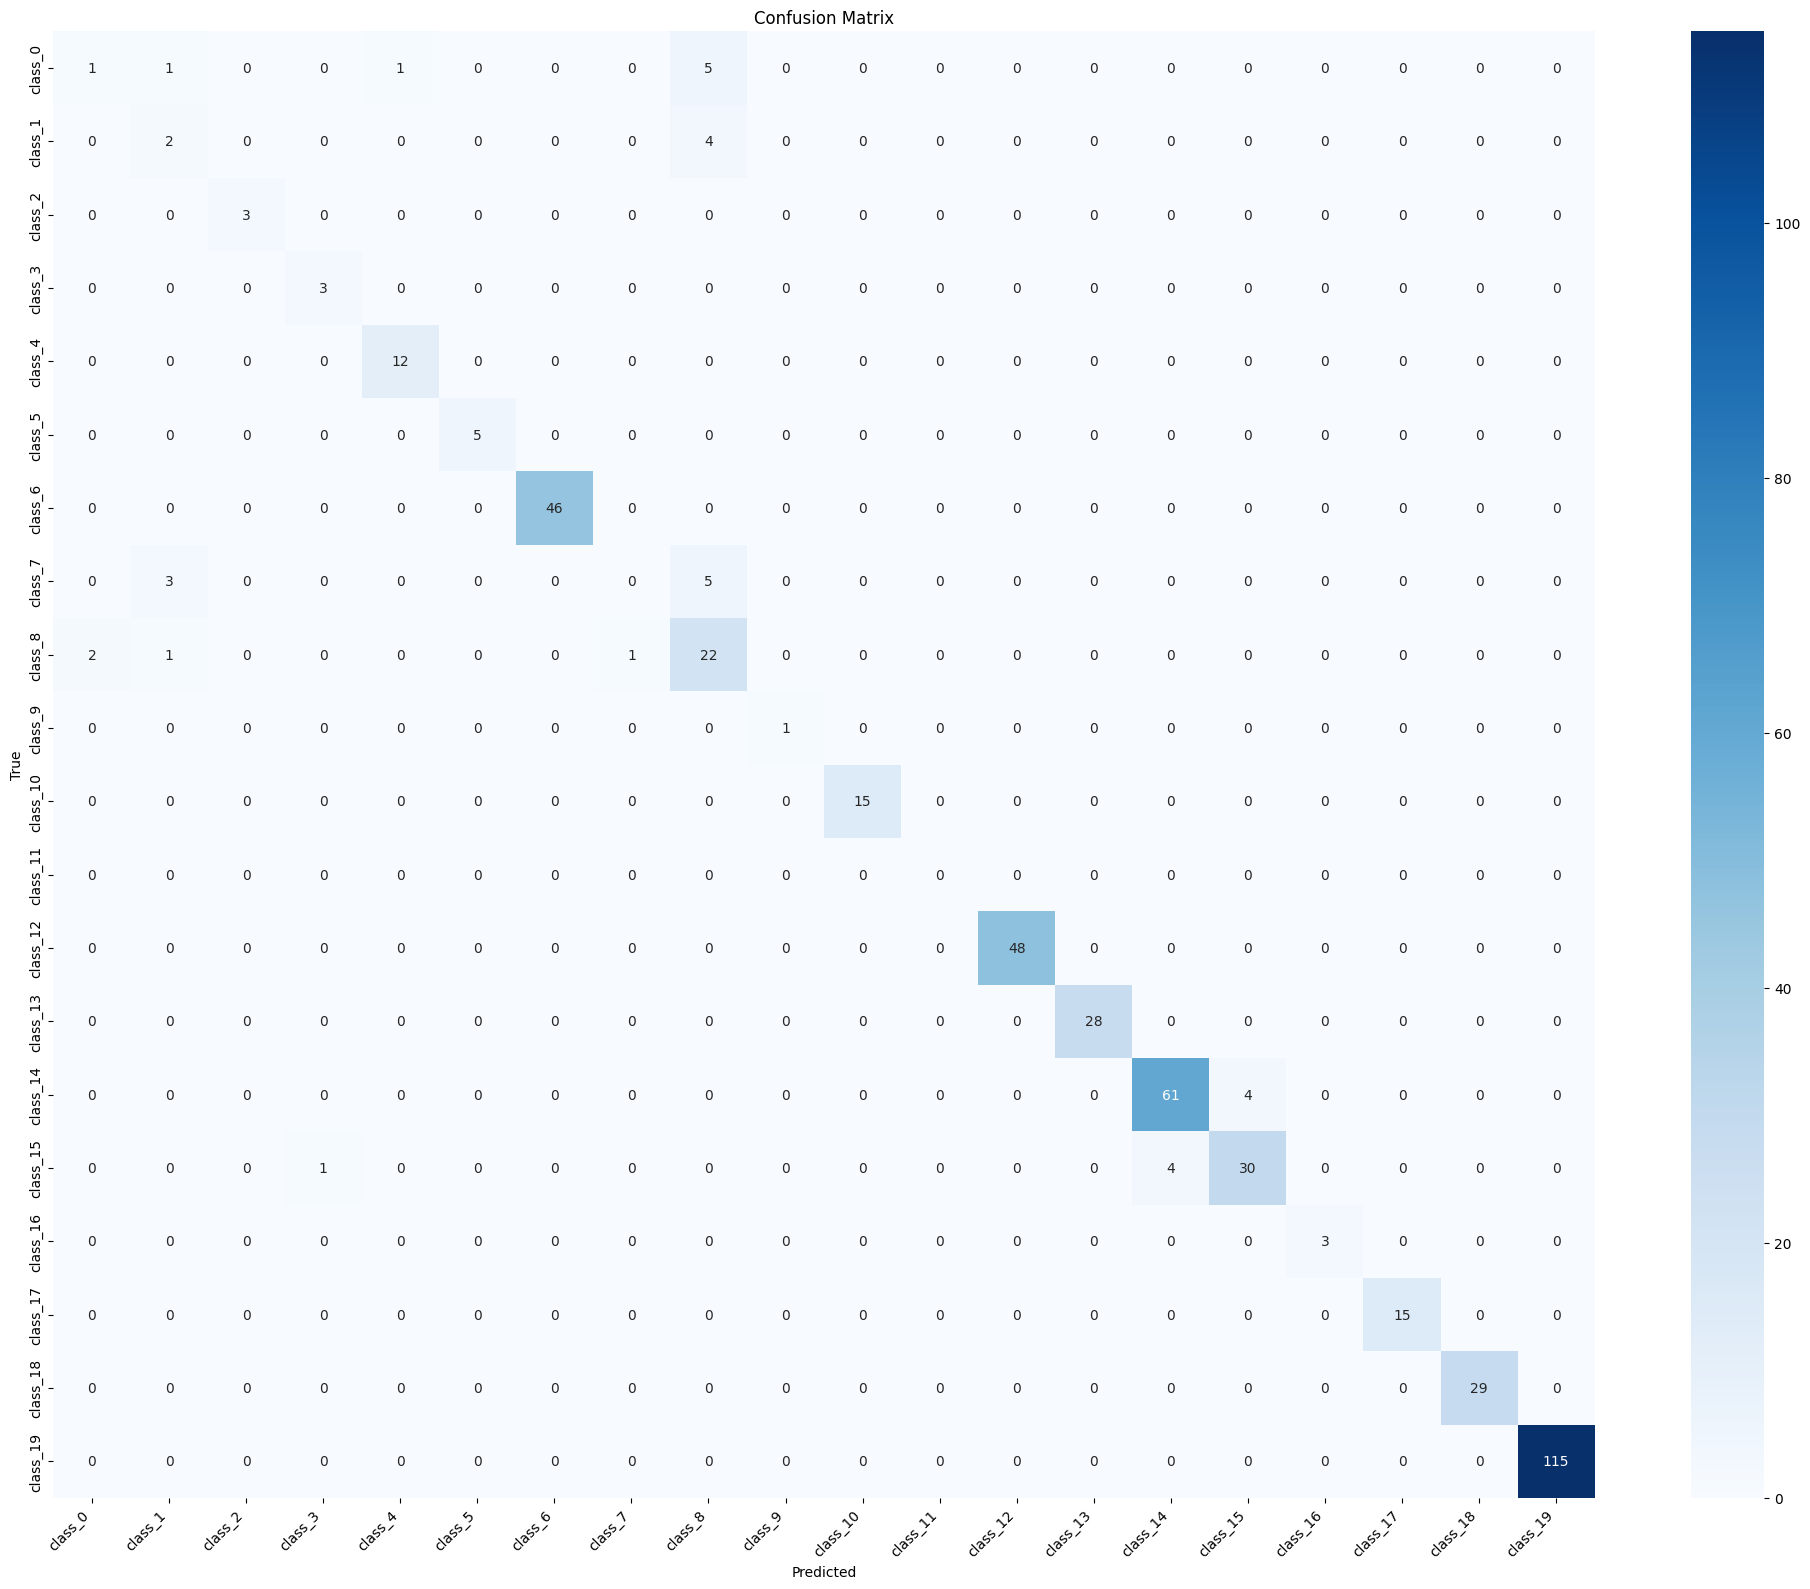

In [13]:
# Confusion Matrix (for top classes)
num_display_classes = min(20, len(class_names))
cm = confusion_matrix(
    all_labels,
    all_predictions,
    labels=range(num_display_classes)
)

plt.figure(figsize=(20, 16))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names[:num_display_classes],
    yticklabels=class_names[:num_display_classes]
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Model Export

Export the model for use in the ensemble

In [14]:
# Bundle everything needed for prediction
export_bundle = {
    'model_state_dict': model.state_dict(),
    'class_mapping': {idx: f"class_{idx}" for idx in range(num_classes)},
    'feature_params': {
        'target_shape': (128, 256),
        'sr': 32000,
        'n_mels': 128,
        'fmin': 500,
        'fmax': 15000,
        'chunk_duration': 5
    },
    'model_architecture': 'BirdCNN-FromScratch',
    'performance': {
        'accuracy': float(accuracy),
        'val_loss': float(best_val_loss)
    }
}

torch.save(export_bundle, 'bird_cnn_scratch_bundle.pth')
print("Model bundle saved to 'bird_cnn_scratch_bundle.pth'")

Model bundle saved to 'bird_cnn_scratch_bundle.pth'


In [15]:
class BirdMelFeatureExtractor:
    def __init__(self, target_shape=(128, 256), chunk_duration=5, sr=32000,
                n_mels=128, fmin=20, fmax=16000):
        """
        Initialize the FeatureExtractor for bird audio.

        Parameters:
        - target_shape (tuple): The target shape for resized mel spectrograms (height, width).
        - chunk_duration (int): Duration of each audio chunk in seconds.
        - sr (int): Sample rate
        - n_mels (int): Number of mel bands
        - fmin, fmax (int): Min and max frequency for mel filters
        """
        self.target_shape = target_shape
        self.chunk_duration = chunk_duration
        self.sr = sr
        self.n_mels = n_mels
        self.fmin = fmin
        self.fmax = fmax

    def load_audio(self, file_path):
        """
        Load an audio file and resample to target sr.
        """
        try:
            audio, orig_sr = sf.read(file_path)
            if len(audio.shape) > 1:  # Stereo to mono
                audio = audio.mean(axis=1)
            if orig_sr != self.sr:
                audio = librosa.resample(audio, orig_sr=orig_sr, target_sr=self.sr)
            return audio, self.sr
        except Exception as e:
            print(f"Error loading audio file {file_path}: {e}")
            return None, None

    def compute_melspec(self, audio):
        """
        Compute a mel-spectrogram from an audio signal with normalization.
        """
        # Apply a small offset to avoid log(0)
        melspec = librosa.feature.melspectrogram(
            y=audio,
            sr=self.sr,
            n_mels=self.n_mels,
            fmin=self.fmin,
            fmax=self.fmax
        )

        # Convert to dB scale
        melspec_db = librosa.power_to_db(melspec, ref=np.max)

        # Normalize to [0, 1] range for better training
        melspec_normalized = (melspec_db - melspec_db.min()) / (melspec_db.max() - melspec_db.min() + 1e-8)

        return melspec_normalized

    def extract_features_from_file(self, file_path, label_idx):
        """
        Extract features from a single audio file.
        Returns features and labels for this file.
        """
        data = []
        labels = []

        try:
            # Load the audio file
            audio, sr = self.load_audio(file_path)
            if audio is None:
                return data, labels

            # Find how many full chunks we can extract
            chunk_samples = int(self.chunk_duration * sr)
            num_chunks = max(1, len(audio) // chunk_samples)

            # For very short files, pad the audio
            if len(audio) < chunk_samples:
                audio = np.pad(audio, (0, chunk_samples - len(audio)), mode='constant')
                num_chunks = 1

            # Extract chunks and compute spectrograms
            for i in range(num_chunks):
                start = i * chunk_samples
                end = min(start + chunk_samples, len(audio))

                # Get audio chunk
                chunk = audio[start:end]

                # Check if the chunk is complete
                if len(chunk) < chunk_samples:
                    # Pad short chunks
                    chunk = np.pad(chunk, (0, chunk_samples - len(chunk)), mode='constant')

                # Compute mel spectrogram
                melspec = self.compute_melspec(chunk)

                # Resize to target shape if needed
                if melspec.shape != self.target_shape:
                    # Using simple resize (can be improved with better interpolation)
                    from skimage.transform import resize
                    melspec = resize(melspec, self.target_shape, mode='constant')

                # Add channel dimension for CNN input
                melspec = np.expand_dims(melspec, axis=0)

                # Append results
                data.append(melspec)
                labels.append(label_idx)

        except Exception as e:
            print(f"Error processing {file_path}: {e}")

        return data, labels

## Inference on New Audio

Make predictions on single audio files

In [16]:
def predict_audio(model, audio_path, label_mapping, feature_extractor=None):
    """
    Make a prediction on a single audio file
    """
    model.eval()

    if feature_extractor is None:
        # Create feature extractor with default parameters if not provided
        feature_extractor = BirdMelFeatureExtractor(
            target_shape=(128, 256),
            chunk_duration=5,
            sr=32000,
            n_mels=128,
            fmin=500,
            fmax=15000
        )

    # Extract features
    features, _ = feature_extractor.extract_features_from_file(audio_path, 0)  # Label doesn't matter here

    if not features:
        return "Could not process audio file"

    # Convert to tensor and move to device
    features_tensor = torch.tensor(np.array(features), dtype=torch.float32).to(device)

    with torch.no_grad():
        # Get model predictions
        outputs = model(features_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)

        # Average probabilities across chunks if multiple
        avg_probs = torch.mean(probabilities, dim=0)

        # Get top 5 predictions
        top_probs, top_indices = torch.topk(avg_probs, k=min(5, len(label_mapping)))

        # Format results
        results = [
            (label_mapping[idx.item()], prob.item()) for idx, prob in zip(top_indices, top_probs)
        ]

        return results

# Test on a sample audio file if available
try:
    test_file = os.path.join(AUDIO_DIR, train_df['filename'].iloc[0])
    label_mapping = {idx: f"class_{idx}" for idx in range(num_classes)}

    # Create feature extractor for inference
    inference_extractor = BirdMelFeatureExtractor(
        target_shape=(128, 256),
        chunk_duration=5,
        sr=32000,
        n_mels=128,
        fmin=500,
        fmax=15000
    )

    predictions = predict_audio(
        model,
        test_file,
        label_mapping,
        inference_extractor
    )

    print(f"File: {test_file}")
    print("Top predictions:")
    for bird_class, probability in predictions:
        print(f"{bird_class}: {probability:.4f}")
except Exception as e:
    print(f"Error running inference: {e}")

File: /content/drive/MyDrive/birdclef-2025-data/train_audio/1139490/CSA36385.ogg
Top predictions:
class_0: 0.7810
class_8: 0.1808
class_59: 0.0157
class_7: 0.0117
class_1: 0.0061
